<a href="https://colab.research.google.com/github/arashfahim/Stochastic_Control_FSU/blob/main/Deep_BSDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# !git clone https://github.com/arashfahim/Stochastic_Control_FSU

In [14]:
# ! ls -l

In [15]:
# path = r'/content/Stochastic_Control_FSU/arashfahim/Stochastic_Control_FSU/'

In [16]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

# Sotchastic control and BSDEs

The goal of this notebook is to implement a BSDE dynamic programming principle, DPP, for a stochastic control problem.

The stochastic control problem is given by

$\inf_{u}\mathbb{E}\bigg[\int_{0}^{T}e^{-rt}C(t,X^u_t,u_t)dt+e^{-rT}g(X^u_T)\bigg]$

with

$dX^u_t=\mu(t,X^u_t,u_t)dt+\sigma(t,X^u_t,u_t)dB_t$



We assume that $\sigma$ does not depend on $u$. When $\sigma$ depends on $u$, the BSDE is second order and more involve.

$dX^u_t=\mu(t,X^u_t,u_t)dt+\sigma(t,X^u_t)dB_t$

The HJB is given by

$\begin{cases}
\partial_t V(t,x) + \frac{\sigma^2(t,x)}{2}\partial^2_x V(t,x) -rV(t,x) + F(t,x,\partial_x V(t,x))=0\\
V(T,x)=g(x)
\end{cases}$

where

$F(t,x,p)=\inf_u\Big\{C(t,x,u)+p\mu(t,x,u)\Big\}$


The BSDE is given by


$Y_t=Y_T+\int_t^T e^{-r(s-t)}\Big(F(s,X_s,Z_s)dt-Z_s\sigma(s,X_s)dB_s\Big)$

Or

$\begin{cases}
dY_t=-F(t,X_t,Z_t)dt+Z_t\sigma(t,X_t)dB_t\\
Y_T=g(X_T)
\end{cases}$

where $dX_t=\sigma(t,X_t)dB_t$ is free of control.


$Y_t$ and $Z_t$ are related to the solution to the HJB by $Y_t=V(t,X_t)$ and $Z_t=\partial_x V(t,X_t)$.


Note that here both $Y$ and $Z$ are unknowns. Particularly, $Y_0=V(0,X_0)$ is not known.

# Numerical approximation of PDEs with BSDEs

We discretize the BSDE:


$\begin{cases}
Y_{t_{i+1}}= Y_{t_i}-F({t_i},X_{t_i},Z_{t_i})dt+Z_{t_i}\sigma({t_i},X_{t_i})\Delta B_{t_{t+1}}\\
Y_T=g(X_T)
\end{cases}$

where $X_{t_{i+1}}=X_{t_i}+\sigma(t_i,X_{t_i})\Delta B_{t_{t+1}}$

If $\hat{Y}$ is an approximate solution to the BSDE through the above method, $\hat{Y}_{t_i}$ is an approximation of $V(t_i,X_{t_i})$. Specifically, if we start from  $\hat{Y}_{0}$ and run the discretize BSDE forward, instead of backward, we must obtain $g(X_T)$ at time $T$.


$\begin{cases}
Y_{t_{i+1}}= Y_{t_i}-F({t_i},X_{t_i},Z_{t_i})dt+Z_{t_i}\sigma({t_i},X_{t_i})\Delta B_{t_{t+1}}\\
Y_0=\Phi(t,x;\alpha)
\end{cases}$


This is a basis for the deep numerical solution for the BSDE. Let's introduce two neural networks ${\hat Y}_{0}=\Phi(x;\alpha)$ and ${\hat Z}_{t}=\Psi(t,x;\beta)$.


Then, simulate $X_0$ by some distribution and increment of Brownina motion to find sample paths through ${\hat X}_{t_{i+1}}={\hat X}_{t_i}+\sigma(t_i,{\hat X}_{t_i})\Delta B_{t_{t+1}}$.

Then, run the BSDE discretization forward in time:


$\begin{cases}
Y_{t_{i+1}}= Y_{t_i}-F({t_i},X_{t_i},\Psi(t_{i},{\hat X}_{t_i};\beta))dt+\Psi(t_{i},{\hat X}_{t_i};\beta)\sigma({t_i},X_{t_i})\Delta B_{t_{t+1}}\\
Y_0=\Phi(x;\alpha)
\end{cases}$


Finally, find optimal $\alpha$ and $\beta$ by

$\inf_{\alpha,\beta}\mathbb{E}\Big[\Big(g({\hat X}_T)-Y_T(\alpha,\beta)\Big)^2\Big]$

In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import time
from time import strftime, localtime
import torch.optim as optim #import optimizer
# import torch.optim.lr_scheduler as lr_scheduler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

M =10000# number of samples
X = torch.normal(0., 1., size=(M,1))# samples for X~N(0,1)
Y = torch.exp(-X)+torch.exp(X)*torch.normal(0., 1., size=(M,1))# samples for Y=e^{-x}+e^{x}N(0,1)
# X.shape
T=1# terminal horizon
N = 10 # of time steps
Dt= torch.Tensor([T/N])# time step size

In [18]:
# create time stamp to save the result
stamp = strftime('%Y-%m-%d %H:%M:%S', localtime())
print(str(stamp))

2024-06-24 10:50:43


## All at once

In [19]:
class terminal(nn.Module):
    def __init__(self,flag,*args):
        super(terminal, self).__init__()
        self.layer = torch.nn.Sequential()
        self.layer.add_module("L1",torch.nn.Linear(1, 16))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L2",torch.nn.Linear(16,1))
        self.flag = flag
    def forward(self, x):
        if self.flag == 'T':
            return torch.Tensor([0.5])*torch.pow(x,2)-x
        else:
            val = self.layer(x)
            return val
        return x

In [20]:
class Z_NN(nn.Module):#multi_step, optimal_control
    def __init__(self):
        super(Z_NN, self).__init__()
        self.layer = torch.nn.Sequential()
        self.layer.add_module("L1",torch.nn.Linear(2, 16))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L2",torch.nn.Linear(16,1))
    def forward(self, tx):
        val = self.layer(tx)
        return val

In [21]:
class Y_NN(nn.Module):#multi_step, optimal_control
    def __init__(self):
        super(Y_NN, self).__init__()
        self.layer = torch.nn.Sequential()
        self.layer.add_module("L1",torch.nn.Linear(1, 16))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L2",torch.nn.Linear(16,1))
    def forward(self, tx):
        val = self.layer(tx)
        return val

In [22]:
class BSDE(classmethod):#multi_step, optimal_control
    def __init__(self,terminal):
        self.Y_NN = Y_NN()
        self.Z_NN = Z_NN()
        self.M = 10000# number of samples
        self.Te = 1.0 # terminal time
        self.K = 20 # total number of steps
        self.Dt= torch.Tensor([self.Te/self.K]) #time step
        self.num_steps = 5 #number of steps to evaluate <= self.K
        self.terminal = terminal # terminal value function
        self.X0 = torch.normal(0., 1., size=(self.M,1))
        for i in range(self.K):# create time data points
            if i == 0:
                T = torch.Tensor([0.0]).repeat([self.M,1])
            else:
                D = i*self.Dt# time step i
                T = torch.cat((T,D.repeat([self.M,1])),axis=1)
        self.T = T.unsqueeze(2)
        self.B = torch.normal(0., 1., size=(self.M,self.K,1))
        for i in range(self.K-self.num_steps,self.K):
                if i == self.K-self.num_steps:
                    update = torch.cat((self.T[:,i],self.X0),axis=1)# cat time and space
                    self.TX = update.unsqueeze(-1) # add dimension for bmm
                else:
                    X = update[:,1].unsqueeze(-1)# slice space for update
                    X = X +  torch.sqrt(self.Dt)*self.B[:,i-1] #update, += is prohibited here because it fundamentally change
                    update = torch.cat((self.T[:,i],X),axis=1) # cat  time and space
                    self.TX = torch.cat((self.TX,update.unsqueeze(-1)),axis=-1) # cat to previous data
        X = update[:,1].unsqueeze(-1) #slice last space
        X = X +  torch.sqrt(self.Dt)*self.B[:,-1]# last update, += is prohibited here
        update = torch.cat((torch.Tensor([self.Te]).repeat([self.M,1]),X),axis=1) # last cat
        self.TX = torch.cat((self.TX,update.unsqueeze(-1)),axis=-1) #last cat to previous data

    def F(self,tx):#take a [N,1] tensor
        # tx = torch.cat((t,x),axis=1)
        return torch.Tensor([0.5])*torch.pow(self.Z_NN.forward(tx),2)-self.Z_NN.forward(tx)*(tx[:,1].unsqueeze(-1))

    def loss(self):
        for i in range(self.K-self.num_steps,self.K):
                if i == self.K-self.num_steps:
                    # print(self.TX[:,1,0].shape)
                    Y = self.Y_NN(self.TX[:,1,0].unsqueeze(-1))
                else:
                    # print(self.TX[:,:,i-self.K+self.num_steps].shape,self.Z_NN(self.TX[:,:,i-self.K+self.num_steps]).shape,self.B[:,i-1].shape)
                    Y = Y - self.F(self.TX[:,:,i-self.K+self.num_steps])*self.Dt + self.Z_NN(self.TX[:,:,i-self.K+self.num_steps])*self.B[:,i-1]
        Y = Y - self.F(self.TX[:,:,-1])*self.Dt + self.Z_NN(self.TX[:,:,-1])*self.B[:,-1]
        return torch.mean(torch.pow(self.terminal(self.TX[:,1,-1]).unsqueeze(-1)-Y,2)) #mean value of running and terminal

In [23]:
g = terminal('T')
v2 = BSDE(g)
# v2.value()

In [24]:
torch.autograd.set_detect_anomaly(True);

In [25]:
loss_epoch = []
num_epochs = 1000
lr = 1e-2
parameters = list(v2.Y_NN.parameters()) + list(v2.Z_NN.parameters())
optimizer2 = optim.Adam(parameters, lr)
L_ = torch.Tensor([-2.0])
loss = torch.Tensor([2.0])
epoch=0
while (torch.abs(L_-loss)>1e-8) & (epoch <= num_epochs):# epoch in range(num_epochs):
  optimizer2.zero_grad()
  loss= v2.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
  loss.backward()
  optimizer2.step()
  loss_epoch.append(loss)
  if epoch>0:
    L_ = loss_epoch[epoch-1]
  if (epoch % 10==0):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
  epoch += 1

At epoch 0 the mean error is 1.7370564937591553.
At epoch 10 the mean error is 0.6202980279922485.
At epoch 20 the mean error is 0.4390861690044403.
At epoch 30 the mean error is 0.3518190085887909.
At epoch 40 the mean error is 0.2685922384262085.
At epoch 50 the mean error is 0.21885952353477478.
At epoch 60 the mean error is 0.17509832978248596.
At epoch 70 the mean error is 0.14207538962364197.
At epoch 80 the mean error is 0.11567112058401108.
At epoch 90 the mean error is 0.09531809389591217.
At epoch 100 the mean error is 0.08018633723258972.
At epoch 110 the mean error is 0.06908099353313446.
At epoch 120 the mean error is 0.0609128400683403.
At epoch 130 the mean error is 0.05479263886809349.
At epoch 140 the mean error is 0.05008094012737274.
At epoch 150 the mean error is 0.046355243772268295.
At epoch 160 the mean error is 0.04332895576953888.
At epoch 170 the mean error is 0.04080020263791084.
At epoch 180 the mean error is 0.038631416857242584.
At epoch 190 the mean error

## Value function

In [26]:
x_ = v2.TX[:,1,-5].detach()
x_T = v2.TX[:,1,-1].detach()
y_ = v2.Y_NN(x_.unsqueeze(-1)).squeeze(-1).detach()

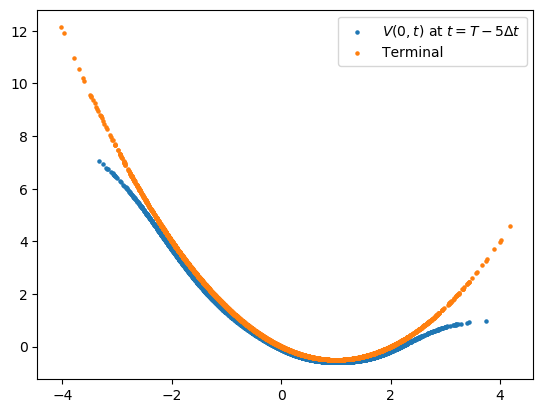

In [27]:
fig = plt.figure()
plt.scatter(x_.numpy(),y_.numpy(),s=5,label=r'$V(0,t)$ at $t=T-5\Delta t$',marker='o');
plt.scatter(x_T.numpy(),v2.terminal(x_T).detach().numpy(),s=5,label='Terminal',marker='o');

plt.legend();
plt.show();